In [1]:
"""
Chained evaluation of the models.
"""
%cd /ibex/user/slimhy/Shape2VecSet/code

import numpy as np
from eval.metrics import run_exps
from eval.model_map import MODEL_MAP
from eval.utils import display_latex, init_exps
from models.pc_ae import load_pretrained_pc_ae
from transforms import get_pc_ae_transform

/ibex/user/slimhy/Shape2VecSet/code
Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


In [2]:
CKPT_ROOT = "/ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/"
AE_MODEl_NAME = "pc_ae"
AE_MODEL_PATH = "/ibex/user/slimhy/Shape2VecSet/ckpt/pc_ae/best_model.pt"

ae_model = None
mean_results = {}
row_entries = {}

for k, model_map in enumerate(MODEL_MAP):
    args, model, device = init_exps(
        model_map["model_name"], CKPT_ROOT + model_map["checkpoint"], AE_MODEl_NAME
    )

    # Get the point cloud transform
    pc_t = get_pc_ae_transform(args)

    # Instantiate autoencoder
    if ae_model is None:
        ae_model, _ = load_pretrained_pc_ae(AE_MODEL_PATH)
        ae_model = ae_model.to(device)
        ae_model = ae_model.eval()

    full_results = run_exps(args, model, ae_model, device, pc_t)
    mean_results[model_map["model_name"]] = full_results["mean"]
    row_entries[model_map["model_name"]] = full_results["tuples"]

### Detailed chain-wise metrics

In [3]:
table_header = """
\\begin{tabular}{@{}lcccccccccccccccccccccccccc@{}}
    \\toprule
    \multicolumn{1}{c}{\multirow{2}{*}{\\textbf{Model}}} & \multicolumn{1}{c}{\multirow{2}{*}{decoupled?}}
    &  & \multicolumn{6}{c}{$|\mathcal{P}|$ = 10}
    &  & \multicolumn{6}{c}{$|\mathcal{P}|$ = 15}
    &  & \multicolumn{6}{c}{$|\mathcal{P}|$ = 20} \\\\ \cmidrule(l){4-23}
    \multicolumn{1}{c}{}  & \multicolumn{1}{c}{}
    &
    & $\\textsc{F}_{\\textsc{CD} - \\textsc{Rec}}$
    & \multicolumn{1}{c}{$\\textsc{A}_{\\textsc{CD} - \\textsc{Rec}}$}
    & $\\textsc{F}_{\\textsc{CD} - \\textsc{Real}}$
    & \multicolumn{1}{c}{$\\textsc{A}_{\\textsc{CD} - \\textsc{Real}}$}
    & \multicolumn{1}{c}{$\\textsc{F}_{\mathcal{L}_2}$}
    & \multicolumn{1}{c}{$\\textsc{A}_{\mathcal{L}_2}$}
    &
    & $\\textsc{F}_{\\textsc{CD} - \\textsc{Rec}}$
    & \multicolumn{1}{c}{$\\textsc{A}_{\\textsc{CD} - \\textsc{Rec}}$}
    & $\\textsc{F}_{\\textsc{CD} - \\textsc{Real}}$
    & \multicolumn{1}{c}{$\\textsc{A}_{\\textsc{CD} - \\textsc{Real}}$}
    & \multicolumn{1}{c}{$\\textsc{F}_{\mathcal{L}_2}$}
    & \multicolumn{1}{c}{$\\textsc{A}_{\mathcal{L}_2}$}
    &
    & $\\textsc{F}_{\\textsc{CD} - \\textsc{Rec}}$
    & \multicolumn{1}{c}{$\\textsc{A}_{\\textsc{CD} - \\textsc{Rec}}$}
    & $\\textsc{F}_{\\textsc{CD} - \\textsc{Real}}$
    & \multicolumn{1}{c}{$\\textsc{A}_{\\textsc{CD} - \\textsc{Real}}$}
    & \multicolumn{1}{c}{$\\textsc{F}_{\mathcal{L}_2}$}
    & \multicolumn{1}{c}{$\\textsc{A}_{\mathcal{L}_2}$} \\\\ \midrule
"""
table_entry = "    & & %s & \multicolumn{1}{c}{%s} & \multicolumn{1}{c}{%s} & \multicolumn{1}{c}{%s} & \multicolumn{1}{c}{%s} & \multicolumn{1}{c}{%s}"
table_sep = "\\arrayrulecolor{black!30}\midrule\\arrayrulecolor{black!100}"
table_footer = """
    \\bottomrule
\end{tabular}%
"""
table_is_decoupled = "& \multicolumn{1}{c}{\%s}"

In [4]:
results_np = np.array([np.array(row_entries[model_name]).flatten() for model_name in row_entries.keys()])

# Mark the maximum column-wise
model_rows = {}
for k, (model_name, results) in enumerate(row_entries.items()):
    results = np.array(results).flatten()
    results_txt = ["\\textbf{%.3f}" % j if j == np.min(results_np[:, i]) else "%.3f" % j for i, j in enumerate(results)]
    model_rows[model_name] = (table_entry*3) % tuple(results_txt)

In [5]:
# Generate LaTeX table
line_seps = [4]
output_table = ""
output_table += table_header
for k, model_map in enumerate(MODEL_MAP):
    if model_map["model_name"] not in model_rows:
        continue
    model_name = model_map["model_name"]
    output_table += "$" + model_map["method_code"] + "$"
    output_table += table_is_decoupled % ("icoyes" if model_map["is_decoupled"] else "icono")
    output_table += model_rows[model_name]
    output_table += "\\\\"
    output_table += "\n"
    if k in line_seps:
        output_table += table_sep
        output_table += "\n"
output_table += table_footer

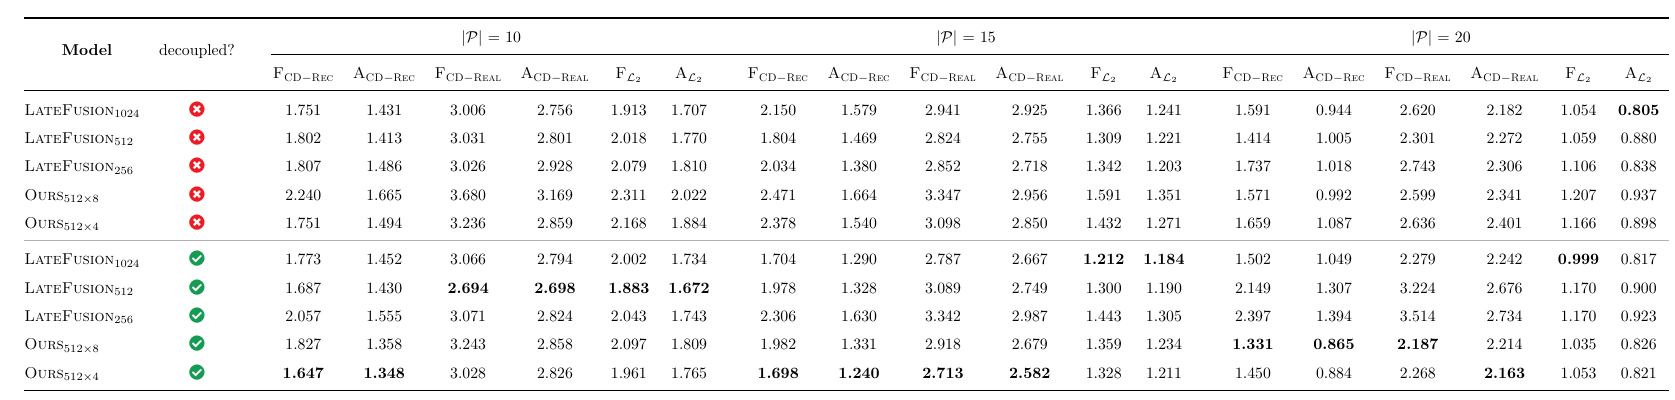

In [6]:
display_latex(output_table, crop_zone=(50, 210, 1725, 610))

In [7]:
# Write to __latex__/pc_ae_oracle.tex
with open("eval/__latex__/pc_ae_eval__all.tex", "w") as f:
    f.write(output_table)

### Average metrics

In [8]:
table_header = r"""
\begin{tabular}{@{}lllccccccc@{}}
    \toprule
    \multicolumn{1}{c}{\multirow{2}{*}{\textbf{Model}}} & \multicolumn{1}{c}{\multirow{2}{*}{decoupled?}} & \multicolumn{1}{c}{} & \multicolumn{6}{c}{Averaged $\ \forall |\mathcal{P}|$} \\  \cmidrule(l){4-9} 
    \multicolumn{1}{c}{} & \multicolumn{1}{c}{}
    & & $\textsc{F}_{\textsc{CD} - \textsc{Rec}}$
    & $\textsc{A}_{\textsc{CD} - \textsc{Rec}}$
    & $\textsc{F}_{\textsc{CD} - \textsc{Real}}$
    & $\textsc{A}_{\textsc{CD} - \textsc{Real}}$
    & $\textsc{F}_{\mathcal{L}_2}$ & $\textsc{A}_{\mathcal{L}_2}$ \\ \midrule
"""
table_entry = "    & & %s & %s & %s & %s & %s & %s"
table_footer = r"""\bottomrule
\end{tabular}%"""

In [9]:
mean_results_np = np.array([np.array(list(mean_results[model_name].values())) for model_name in mean_results.keys()])
# Mark the maximum column-wise
model_rows = {}
for k, (model_name, results) in enumerate(mean_results.items()):
    results = np.array(list(results.values()))
    results_txt = ["\\textbf{%.3f}" % j if j == np.min(mean_results_np[:, i]) else "%.3f" % j for i, j in enumerate(results)]
    model_rows[model_name] = (table_entry) % tuple(results_txt)

In [10]:
# Generate LaTeX table
output_table = ""
output_table += table_header
output_table += "\n"
line_seps = [4]
for k, model_map in enumerate(MODEL_MAP):
    if model_map["model_name"] not in model_rows:
        continue
    model_name = model_map["model_name"]
    output_table += "$" + model_map["method_code"] + "$\n"
    output_table += table_is_decoupled % ("icoyes" if model_map["is_decoupled"] else "icono")
    output_table += model_rows[model_name]
    output_table += "\\\\"
    output_table += "\n"
    if k in line_seps:
        output_table += table_sep
        output_table += "\n"
    output_table += "\n"
output_table += table_footer

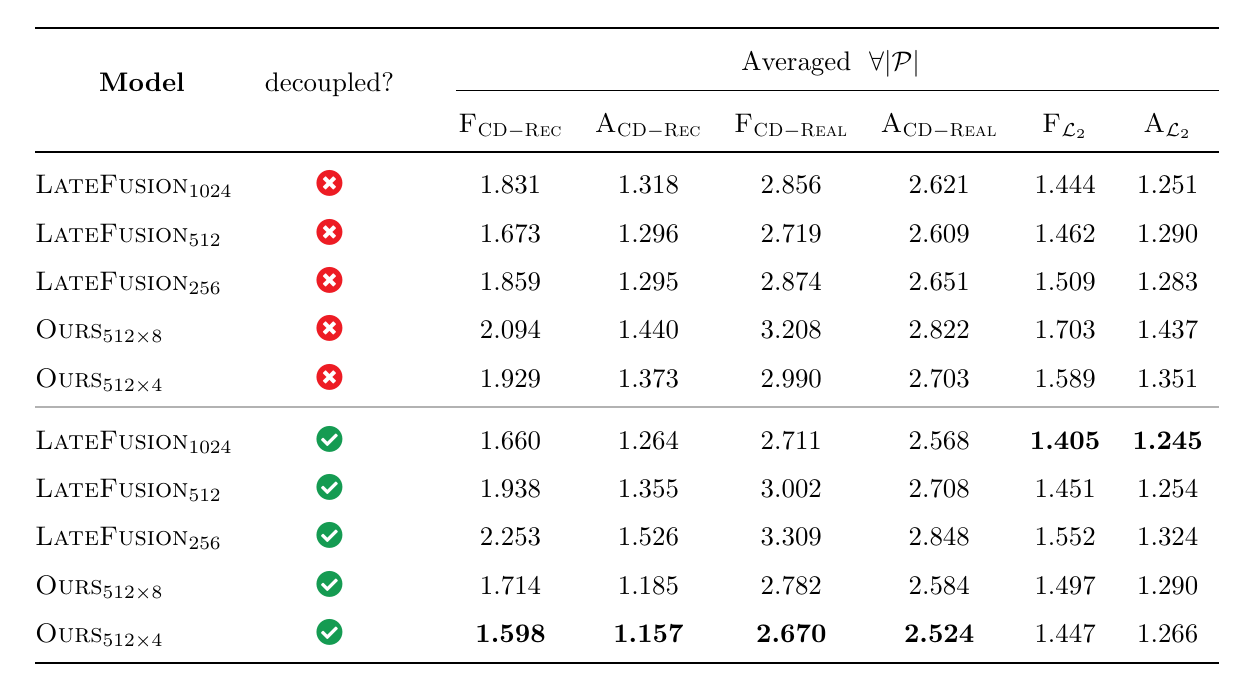

In [11]:
display_latex(output_table, crop_zone=(500, 200, 1735, 900), hspace=0)

In [12]:
# Write to __latex__/pc_ae_oracle.tex
with open("eval/__latex__/pc_ae_eval__averaged.tex", "w") as f:
    f.write(output_table)